In [1]:
import pandas as pd
from tech_core.feature_pipeline import FeaturesPipeline
from tech_core.losses import StreamingSharpeLoss
from tech_core.nn_builder import SimplePortfolioAllocator, DeepPortfolioAllocator_1
import torch
from tqdm import tqdm
# ??? Should we make different train periods for different models?

In [2]:
path_to_data = '../data/'

split_dates = [
    pd.Timestamp("2025-01-01")
]
split_names = ['train', 'test']

fee = 1.53e-4
padding = 35
batch_size_config = {
    0: 1000,
    # 40: 4000,
    # 80: 10000
}
num_epochs = 200
adam_lr = 1e-2
log_freq = 5

In [3]:
prev_models = []

batch_size = batch_size_config[0]
pipeline = FeaturesPipeline(
    path_to_data,
    padding=padding,
    batch_size=batch_size,
    split_dates=split_dates,
    split_names=split_names
)

cmf_dim = asset_dim = num_assets = None
for common_feats, asset_feats, fut_ret, _, _ in tqdm(pipeline.iterate('train'), desc="Loading features"):
    cmf_dim = common_feats.shape[1]
    asset_dim = asset_feats.shape[2]
    num_assets = asset_feats.shape[1]
    break
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Loading features: 0it [00:00, ?it/s]


  0%|          | 0/200 [00:00<?, ?it/s]

Sharpe Ratio for the epoch: -22.1051
Average Weights:



,Weight
AAPL,0.053280
NVDA,0.045690
MSFT,0.044959
AMZN,0.032757
GOOGL,0.032571
...,...
XRAY,0.000044
DXC,0.000036
OGN,0.000035
NWL,0.000032


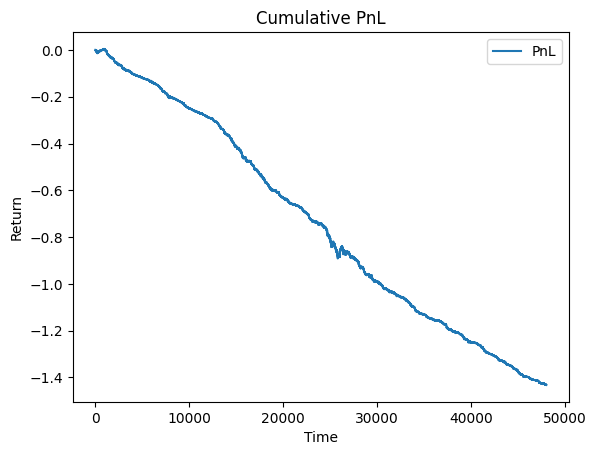

Changing batch size to 1000 at epoch 0


  2%|▏         | 4/200 [03:35<2:49:12, 51.80s/it]

Sharpe Ratio for the epoch: -4.9026
Average Weights:



,Weight
Cash,5.243906e-01
NVDA,2.143373e-01
TSLA,2.517149e-03
META,1.263691e-03
AMZN,1.163085e-03
...,...
SEDG,5.150615e-07
NWL,4.895384e-07
DXC,4.642685e-07
OGN,4.365285e-07


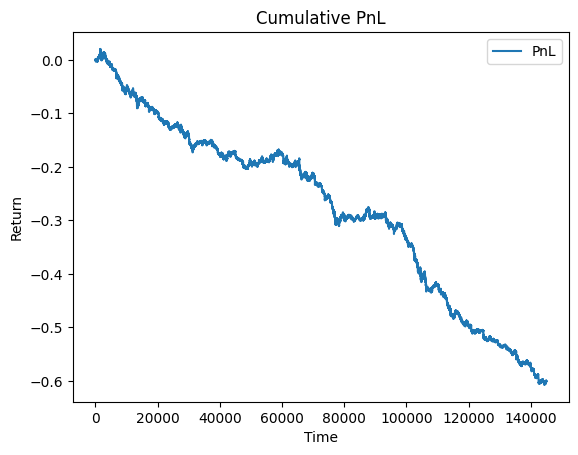

Epoch 5: Loss = -1.3720811605453491


  2%|▏         | 4/200 [04:13<3:27:10, 63.42s/it]


KeyboardInterrupt: 

In [4]:
from copy import deepcopy

loss_fn = StreamingSharpeLoss(
    fee=fee,
    asset_names=pipeline.reader.asset_names + ['Cash'],  # Добавляем Cash в список активов
)

m0 = SimplePortfolioAllocator(
    cmf_dim=cmf_dim + 1,  # +1 for cash_left
    num_assets=num_assets,
).to(device)
m0_path = 'model_iteration_0_epoch_200.pth'
m0.load_state_dict(torch.load(m0_path, map_location=device))
m0.eval()

prev_models = [deepcopy(m0)]  # Start with the first model
for i in range(len(prev_models), 10):

    # ad-hoc so far, mb add this to pipeline
    train_cash_left = []
    for common_feats_old, asset_feats, fut_ret, min_prices, market_caps in pipeline.iterate('train'):

        # Перевод в тензоры
        common_feats = torch.tensor(common_feats_old.values, dtype=torch.float32).to(device)       # (T, d_common)
        asset_feats  = torch.tensor(asset_feats,         dtype=torch.float32).to(device)       # (T, n_assets, d_asset)
        fut_ret      = torch.tensor(fut_ret.values,      dtype=torch.float32).to(device)       # (T, n_assets)
        min_prices  = torch.tensor(min_prices.values,   dtype=torch.float32).to(device)       # (T, n_assets)
        market_caps = torch.tensor(market_caps.values,  dtype=torch.float32).to(device)       # (T, n_assets)

        if len(common_feats) != batch_size:
            continue

        cash_left = torch.ones((common_feats.shape[0], 1), dtype=torch.float32, device=device)  # (T, 1)
        for prev_model in prev_models:
            common_feats_tmp = common_feats_old.copy()
            common_feats_tmp['cash_left'] = cash_left.detach().numpy()
            common_feats_tmp = torch.tensor(common_feats_tmp.values, dtype=torch.float32).to(device)
            cash_left *= prev_model(common_feats_tmp, asset_feats)[:, -1:]

        train_cash_left.append(cash_left.detach())
    
    test_cash_left = []
    for common_feats_old, asset_feats, fut_ret, min_prices, market_caps in pipeline.iterate('test'):

        common_feats = torch.tensor(common_feats_old.values, dtype=torch.float32).to(device)
        asset_feats  = torch.tensor(asset_feats,         dtype=torch.float32).to(device)
        fut_ret      = torch.tensor(fut_ret.values,      dtype=torch.float32).to(device)
        min_prices  = torch.tensor(min_prices.values,   dtype=torch.float32).to(device)
        market_caps = torch.tensor(market_caps.values,  dtype=torch.float32).to(device)
        
        if len(common_feats) != batch_size:
            continue

        cash_left = torch.ones((common_feats.shape[0], 1), dtype=torch.float32, device=device)  # (T, 1)
        for prev_model in prev_models:
            common_feats_tmp = common_feats_old.copy()
            common_feats_tmp['cash_left'] = cash_left.detach().numpy()
            common_feats_tmp = torch.tensor(common_feats_tmp.values, dtype=torch.float32).to(device)
            cash_left *= prev_model(common_feats_tmp, asset_feats)[:, -1:]
        test_cash_left.append(cash_left.detach())
    market_caps = pd.read_csv(path_to_data + 'companies_info.csv')['Marketcap'].values

    model = SimplePortfolioAllocator(
        cmf_dim=cmf_dim + 1,
        num_assets=num_assets,
        is_snp_initialization=True,
        market_caps=market_caps
    ).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=adam_lr)

    for epoch in tqdm(range(num_epochs)):
        if epoch == 0:
            for (common_feats, asset_feats, fut_ret, min_prices, market_caps), cash_left in zip(pipeline.iterate('test'), test_cash_left):

                common_feats['cash_left'] = cash_left.squeeze()

                common_feats = torch.tensor(common_feats.values, dtype=torch.float32).to(device)
                asset_feats  = torch.tensor(asset_feats,         dtype=torch.float32).to(device)
                fut_ret      = torch.tensor(fut_ret.values,      dtype=torch.float32).to(device)
                min_prices  = torch.tensor(min_prices.values,   dtype=torch.float32).to(device)
                market_caps = torch.tensor(market_caps.values,  dtype=torch.float32).to(device)

                if len(common_feats) !=  batch_size:
                    continue

                weights = model(common_feats, asset_feats)
                loss_fn.forward(weights=weights, returns=fut_ret, prev_model_cash=cash_left, min_prices=min_prices, market_caps=market_caps)

            loss_fn.plot_whole_epoch_loss()
            loss_fn.reset()

        if epoch in batch_size_config:
            print(f"Changing batch size to {batch_size_config[epoch]} at epoch {epoch}")
            batch_size = batch_size_config[epoch]
            pipeline = FeaturesPipeline(
                path_to_data,
                padding=padding,
                batch_size=batch_size,
                split_dates=split_dates,
                split_names=split_names
            )
        if epoch == 0:
            loss_fn = StreamingSharpeLoss(
                fee=fee,
                asset_names=pipeline.reader.asset_names + ['Cash']
            )

        if epoch == 100:
            loss_fn = StreamingSharpeLoss(
                fee=fee,
                asset_names=pipeline.reader.asset_names + ['Cash'],
                is_sharpe=False
            )

        loss_fn.reset()
        pipeline.reset()
        for (common_feats, asset_feats, fut_ret, min_prices, market_caps), cash_left in zip(pipeline.iterate('train'), train_cash_left):

            common_feats['cash_left'] = cash_left.squeeze()

            # Перевод в тензоры
            common_feats = torch.tensor(common_feats.values, dtype=torch.float32).to(device)       # (T, d_common)
            asset_feats  = torch.tensor(asset_feats,         dtype=torch.float32).to(device)       # (T, n_assets, d_asset)
            fut_ret      = torch.tensor(fut_ret.values,      dtype=torch.float32).to(device)       # (T, n_assets)
            min_prices  = torch.tensor(min_prices.values,   dtype=torch.float32).to(device)       # (T, n_assets)
            market_caps = torch.tensor(market_caps.values,  dtype=torch.float32).to(device)       # (T, n_assets)

            if len(common_feats) != batch_size:
                continue

            optimizer.zero_grad()

            # Вычисляем веса
            weights = model(common_feats, asset_feats)

            # Обновляем метрику
            loss_value = loss_fn.forward(
                weights=weights,
                returns=fut_ret,
                prev_model_cash=cash_left,
                min_prices=min_prices,
                market_caps=market_caps
            )
            loss_value.backward()

            optimizer.step()

        if (epoch + 1) % log_freq == 0:
            _, weights_df = loss_fn.plot_whole_epoch_loss()
            weights_df.to_csv(f'weights_iteration_{i}_epoch_{epoch + 1}.csv')
            torch.save(model.state_dict(), f'model_iteration_{i}_epoch_{epoch + 1}.pth')
            print(f"Epoch {epoch + 1}: Loss = {loss_value.item()}")
        loss_fn.reset()

        for (common_feats, asset_feats, fut_ret, min_prices, market_caps), cash_left in zip(pipeline.iterate('test'), test_cash_left):

            common_feats['cash_left'] = cash_left.squeeze()

            common_feats = torch.tensor(common_feats.values, dtype=torch.float32).to(device)
            asset_feats  = torch.tensor(asset_feats,         dtype=torch.float32).to(device)
            fut_ret      = torch.tensor(fut_ret.values,      dtype=torch.float32).to(device)
            min_prices  = torch.tensor(min_prices.values,   dtype=torch.float32).to(device)
            market_caps = torch.tensor(market_caps.values,  dtype=torch.float32).to(device)

            if len(common_feats) !=  batch_size:
                continue

            weights = model(common_feats, asset_feats)
            loss_fn.forward(weights=weights, returns=fut_ret, prev_model_cash=cash_left, min_prices=min_prices, market_caps=market_caps)

        if (epoch + 1) % log_freq == 0:
            loss_fn.plot_whole_epoch_loss()
        loss_fn.reset()

    prev_models.append(deepcopy(model))
    print(f"Iteration {i + 1} completed.")

As seen - we collapse to buy and hold (both with sharpe-pnl and pnl).